# COS 424 Assignment 1: Classification of review sentiments

In [4]:
import pandas as pd
import numpy as np
import gensim
import nimfa
import seaborn as sns
from tabulate import tabulate
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn import manifold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from scipy import interp
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## I. Amazon, iMDB, Yelp Dataset

### A. Dataset Processing

**1. Load training and test set from files with relative path "data/"**

In [179]:
X_train_pd = pd.read_csv("data/out_bag_of_words_5.csv", header=None)
X_train = X_train_pd.values
Y_train = np.loadtxt("data/out_classes_5.txt").astype(int)
X_test_pd = pd.read_csv("data/out_bag_of_words_test_0.csv", header=None)
X_test = X_test_pd.values
print(X_test.shape)
Y_test = np.loadtxt("data/out_classes_test_0.txt").astype(int)
X = pd.concat([X_train_pd, X_test_pd]).values
print(X)
Y = np.vstack((Y_train.reshape((Y_train.shape[0],1)), Y_test.reshape((Y_test.shape[0],1))))
print(int(Y[1]))

(600, 541)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0


### B. Dimensionality Reduction

**1. Capturing the amount of information given by cumulative variance of this dataset**

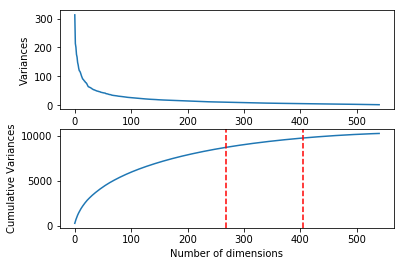

In [191]:
U, S, V_t = np.linalg.svd(X_train, full_matrices=False)
S_sq = np.square(S[:541])
cumsum_vars = np.cumsum(S_sq)
cumsum_tot_vars = np.cumsum(np.square(S))
tot_var = cumsum_tot_vars[-1]
threshold_0 = 0.85 # this roughly corresponds to the elbow of the cumulative sv's graph
threshold_1 = 0.95
mark_0 = 0
mark_1 = 0
for i in range(len(cumsum_vars)):
    if cumsum_vars[i] >= threshold_0*tot_var:
        mark_0 = i
        break
for i in range(len(cumsum_vars)):
    if cumsum_vars[i] >= threshold_1*tot_var:
        mark_1 = i
        break
plt.subplot(211)
plt.plot(S_sq)
plt.ylabel('Variances')
plt.subplot(212)
plt.plot(cumsum_vars)
plt.axvline(mark_0, color='r', linestyle='dashed')
plt.axvline(mark_1, color='r', linestyle='dashed')
plt.xlabel('Number of dimensions')
plt.ylabel('Cumulative Variances')
plt.show()

**2. PCA and t-SNE representation of the data**

(3000, 3)


Text(0.5,1,'BoW components PCA 2d')

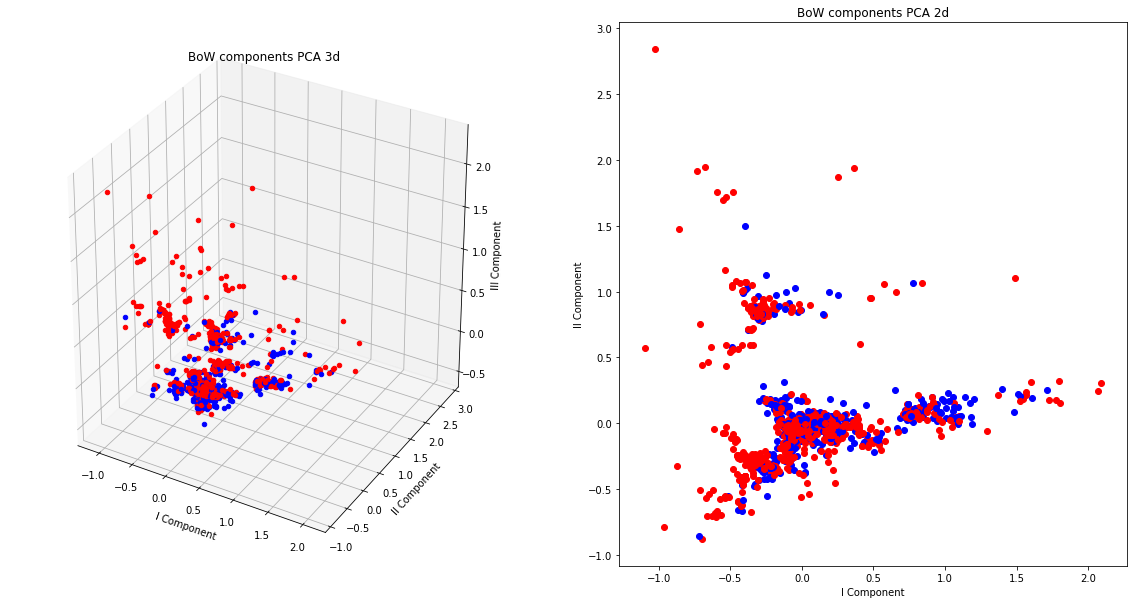

In [189]:
colors = ['blue', 'red']
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(X)
print(X_PCA.shape)
for i in range(X_PCA.shape[0]):
    ax.scatter(X_PCA[i, 0], X_PCA[i, 1], X_PCA[i, 2], c=colors[int(Y[i])])
ax.set_xlabel('I Component')
ax.set_ylabel('II Component')
ax.set_zlabel('III Component')
plt.title('BoW components PCA 3d')
ax = fig.add_subplot(122)
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X)
i = 0
for i in range(X_PCA.shape[0]):
    ax.scatter(X_PCA[i, 0], X_PCA[i, 1], c=colors[int(Y[i])])
ax.set_xlabel('I Component')
ax.set_ylabel('II Component')
plt.title('BoW components PCA 2d')

Text(0.5,1,'BoW components t-SNE 2d')

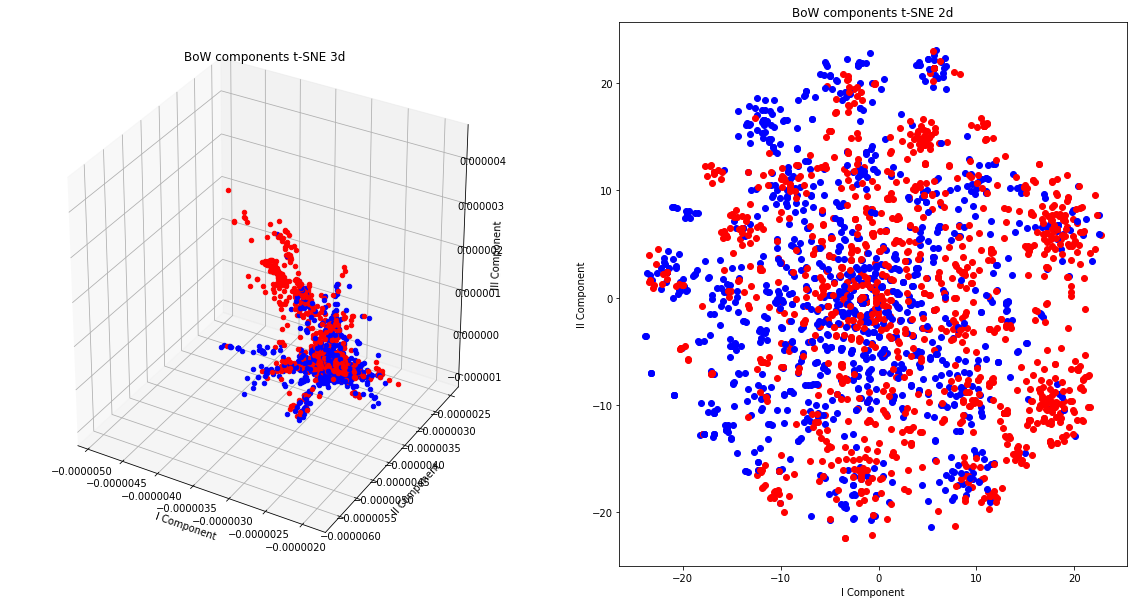

In [190]:
# write that you tried multiple perplexities because they were too high and the dataset looked like a ball
tsne = manifold.TSNE(n_components=3, init='random', learning_rate=10, perplexity = 50, n_iter=2000)
X_tsne = tsne.fit_transform(X_train)
fig = plt.figure(figsize=(20,10))
ax_new = fig.add_subplot(121, projection='3d')
for i in range(X_tsne.shape[0]):
    ax_new.scatter(X_tsne[i, 0], X_tsne[i, 1], X_tsne[i, 2], c=colors[Y_train[i]])
ax_new.set_xlabel('I Component')
ax_new.set_ylabel('II Component')
ax_new.set_zlabel('III Component')
plt.title('BoW components t-SNE 3d')
tsne = manifold.TSNE(n_components=2, init='random', perplexity = 50, learning_rate=20, n_iter=2000)
X_tsne = tsne.fit_transform(X_train)
ax_new = fig.add_subplot(122)
for i in range(X_tsne.shape[0]):
    ax_new.scatter(X_tsne[i, 0], X_tsne[i, 1], c=colors[Y_train[i]])
ax_new.set_xlabel('I Component')
ax_new.set_ylabel('II Component')
plt.title('BoW components t-SNE 2d')

### C. Model Validation

**1. k-fold Cross Validation**

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

In [103]:
def plotROC(model, X, Y):
    cv = StratifiedKFold(n_splits=5)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, Y):
        probas_ = model.fit(X[train], Y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### D. Simple classifiers

**1. Gaussian and Multinomial Naïve Bayes**

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


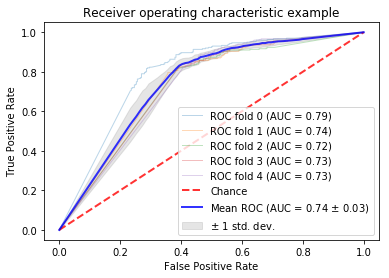

In [115]:
gnb = GaussianNB()
plotROC(gnb, X, Y)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


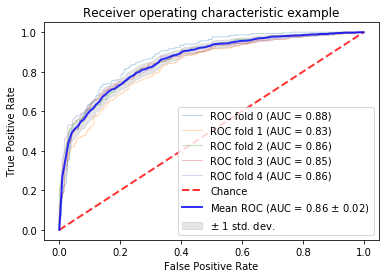

In [116]:
mnnb = MultinomialNB()
plotROC(mnnb, X, Y)

**2. RBF Kernel SVM**

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


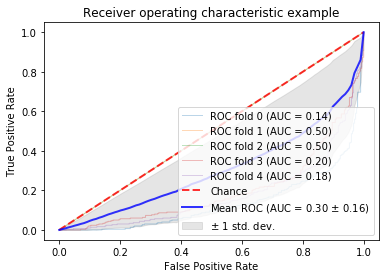

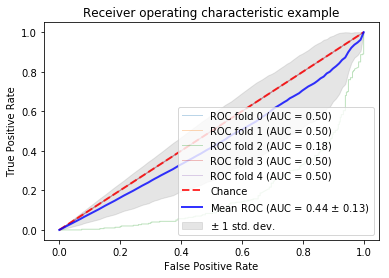

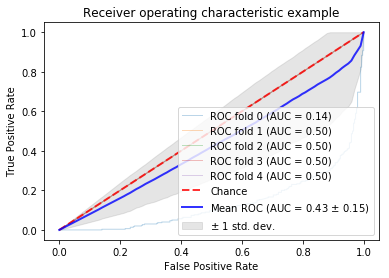

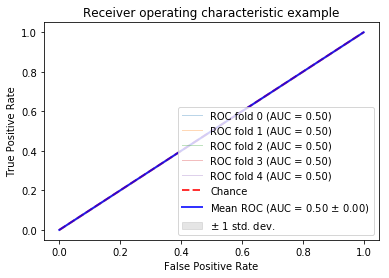

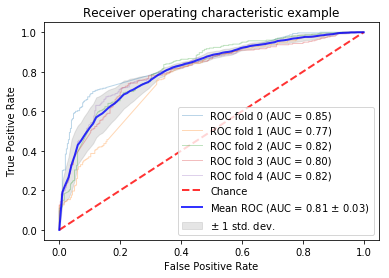

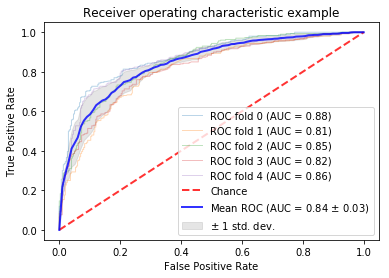

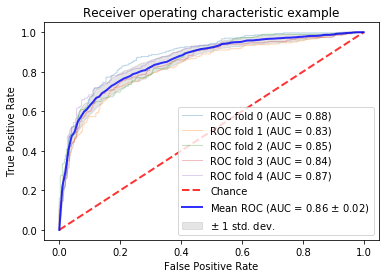

In [120]:
for C in [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]:
    svm = SVC(kernel='rbf', gamma='auto', C=C, probability=True)
    plotROC(svm, X, Y)

**3. k-Nearest Neighbours**

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


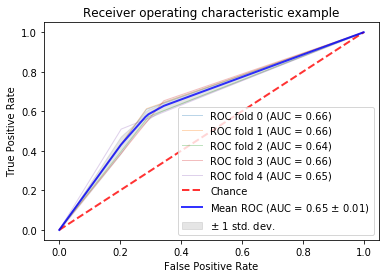

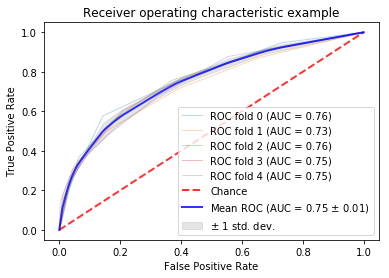

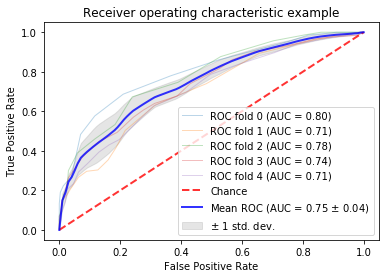

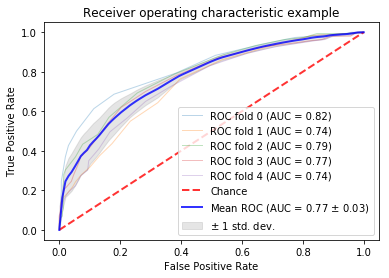

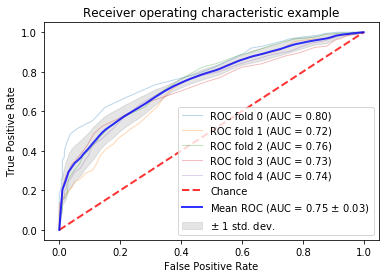

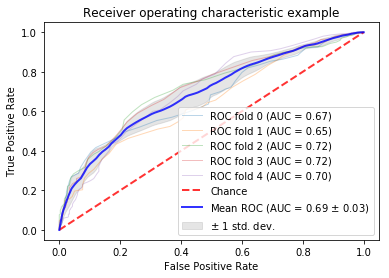

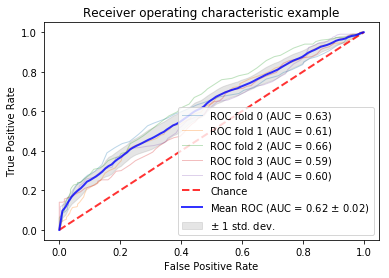

In [126]:
for k in [1, 5, 35, 50, 100, 250, 500]:
    neigh = KNeighborsClassifier(n_neighbors=k)
    plotROC(neigh, X, Y)

### E. Ensemble Classifiers

**1. Random Forest**

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

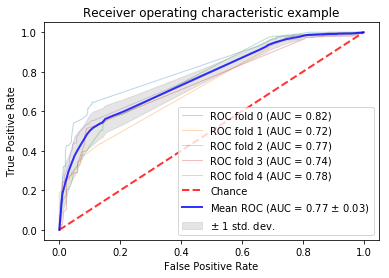

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

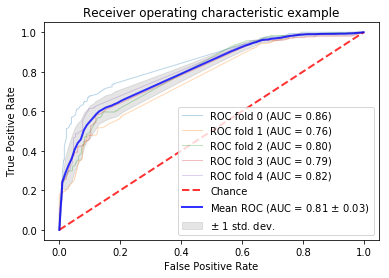

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

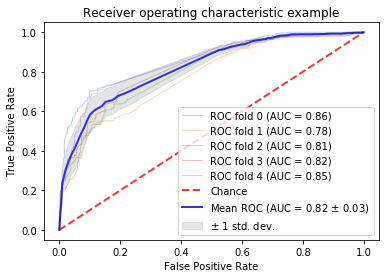

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

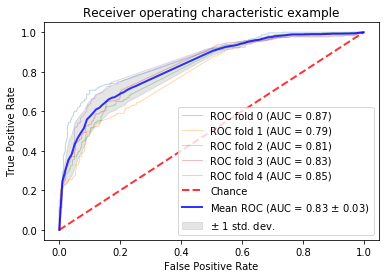

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

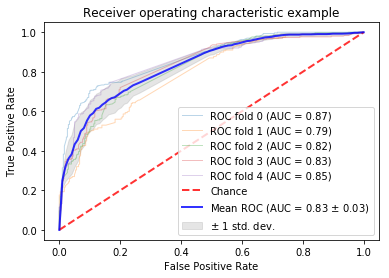

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

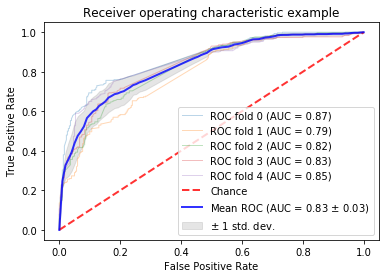

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

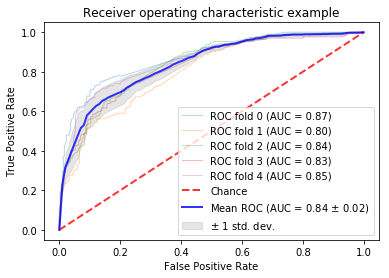

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

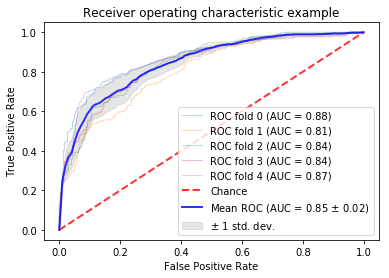

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

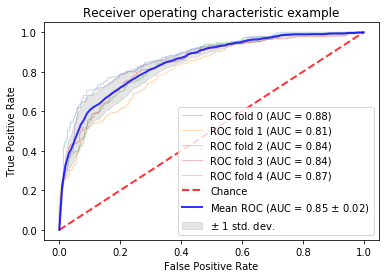

In [131]:
for n in [10, 25, 50, 60, 75, 100, 200, 1000, 10000]:
    randfor = RandomForestClassifier(n_estimators=n, max_depth=8, random_state=0)
    plotROC(randfor, X, Y)

**2. AdaBoost **

a) AdaBoost with Decision Tree as weak learner

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

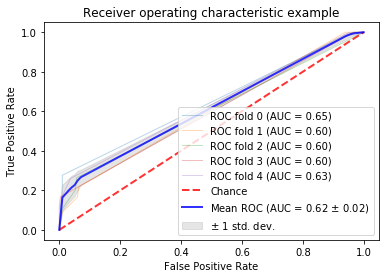

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

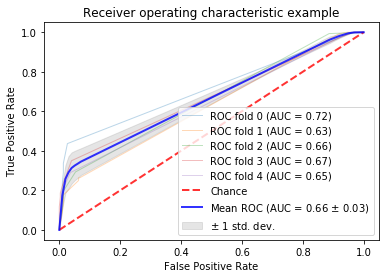

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

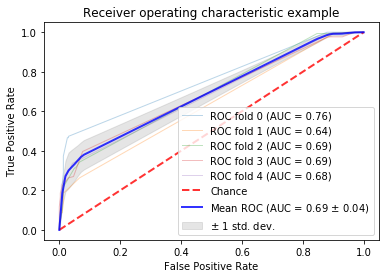

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

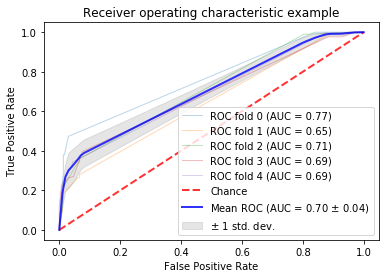

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

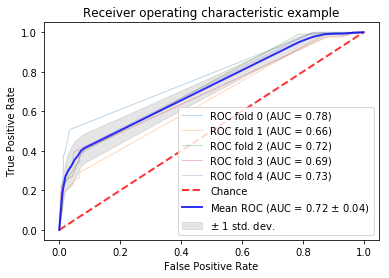

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

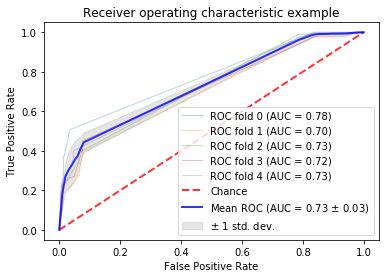

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

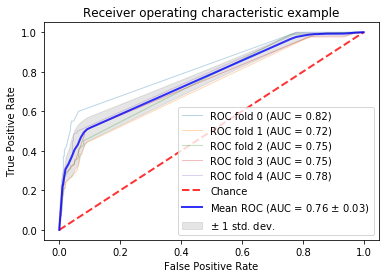

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

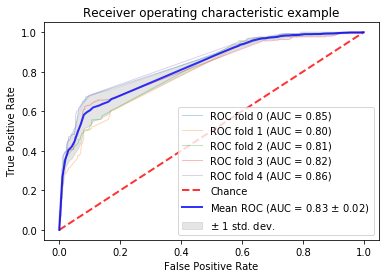

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

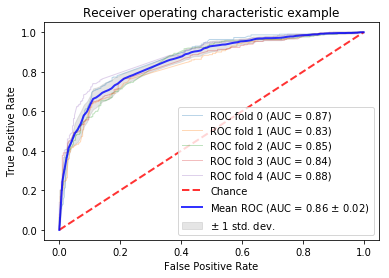

In [195]:
for n in [10, 25, 50, 60, 75, 100, 200, 1000, 10000]:
    adabst = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=n)
    plotROC(adabst, X, Y)

b) AdaBoost with Naïve Bayes as weak learner

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

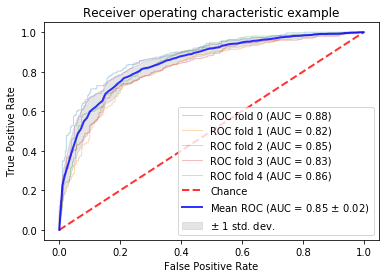

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

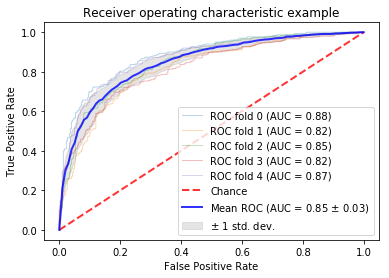

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

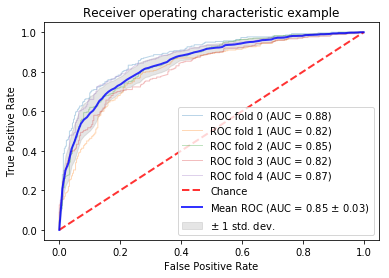

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

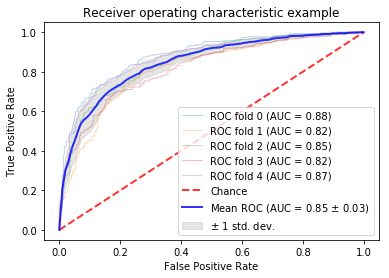

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

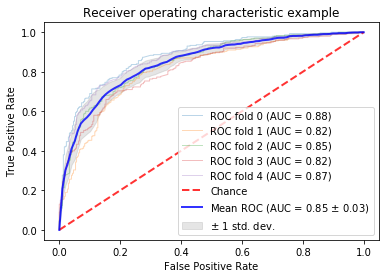

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

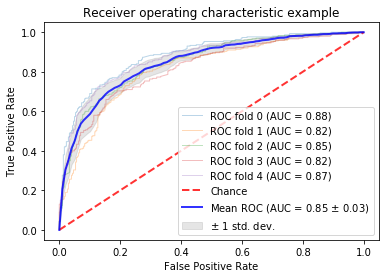

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

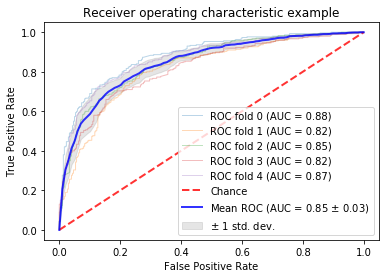

In [196]:
for n in [10, 25, 50, 60, 75, 100, 200]:
    adabst = AdaBoostClassifier(MultinomialNB(), algorithm="SAMME", n_estimators=n)
    plotROC(adabst, X, Y)

c) AdaBoost with Random Forest as weak learner

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

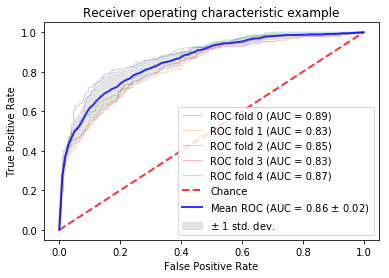

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

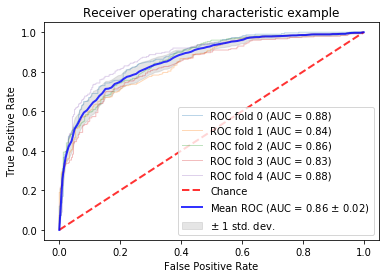

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

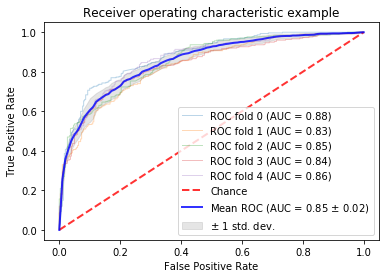

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

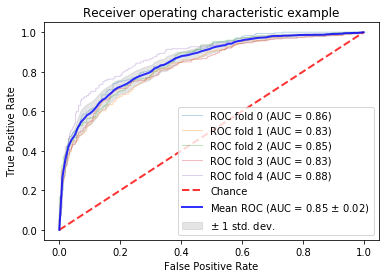

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

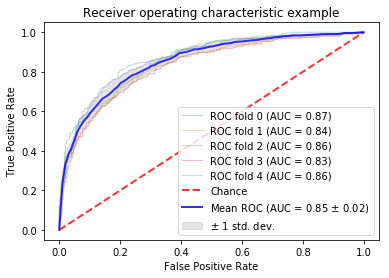

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

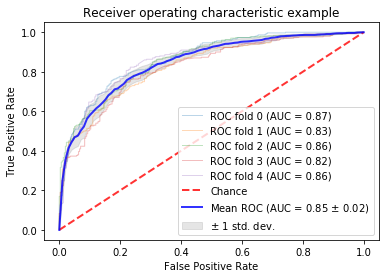

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

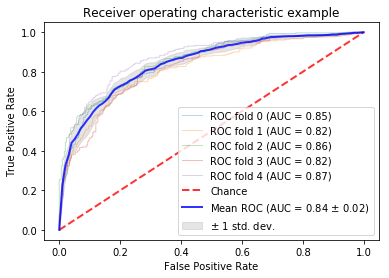

In [199]:
for n in [10, 25, 50, 60, 75, 100, 200]:
    adabst = AdaBoostClassifier(RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0), algorithm="SAMME", n_estimators=n)
    plotROC(adabst, X, Y)

## II. Twitter dataset

### A. Dataset Processing

https://github.com/tthustla/twitter_sentiment_analysis_part1/blob/master/Capstone_part2.ipynb

In [5]:
X_tweets_pd = pd.read_csv("data/tweets.csv", error_bad_lines=False)
Y_tweets = X_tweets_pd['Sentiment'].values
X_tweets_pd.drop(['ItemID', 'SentimentSource'], inplace=True, axis=1)
X_tweets_pd.head(10)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
5,0,or i just worry too much?
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,0,Sunny Again Work Tomorrow :-| ...
8,1,handed in my uniform today . i miss you ...
9,1,hmmmm.... i wonder how she my number @-)


In [6]:
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [7]:
clean_tweet_texts = []
for i in range(0, len(X_tweets_pd['SentimentText'])):
    if( (i+1)%100000 == 0 ):
        print ("Tweets " + str(i+1) + " of 1600000 have been processed")                                                                
    clean_tweet_texts.append(tweet_cleaner(X_tweets_pd['SentimentText'][i]))

Tweets 100000 of 1600000 have been processed
Tweets 200000 of 1600000 have been processed
Tweets 300000 of 1600000 have been processed
Tweets 400000 of 1600000 have been processed
Tweets 500000 of 1600000 have been processed
Tweets 600000 of 1600000 have been processed
Tweets 700000 of 1600000 have been processed
Tweets 800000 of 1600000 have been processed
Tweets 900000 of 1600000 have been processed
Tweets 1000000 of 1600000 have been processed
Tweets 1100000 of 1600000 have been processed
Tweets 1200000 of 1600000 have been processed
Tweets 1300000 of 1600000 have been processed
Tweets 1400000 of 1600000 have been processed
Tweets 1500000 of 1600000 have been processed


In [8]:
print(len(clean_tweet_texts))

1578612


In [9]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['Sentiment'] = X_tweets_pd['Sentiment']
clean_df.to_csv('data/clean_tweet.csv',encoding='utf-8')
X_clean_tweets_pd = pd.read_csv('data/clean_tweet.csv',index_col=0)
print(X_clean_tweets_pd.shape)

(1578612, 2)


/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
X_clean_tweets_pd_red = X_clean_tweets_pd.head(25000)
X_clean_tweets_pd_red.head(10)

,text,Sentiment
0,is so sad for my apl friend,0
1,i missed the new moon trailer,0
2,omg its already o,1
3,omgaga im sooo im gunna cry i ve been at this ...,0
4,i think mi bf is cheating on me t t,0
5,or i just worry too much,0
6,juuuuuuuuuuuuuuuuussssst chillin,1
7,sunny again work tomorrow tv tonight,0
8,handed in my uniform today i miss you already,1
9,hmmmm i wonder how she my number,1


### B. Word2Vec

**1. Loading dataset**

In [11]:
Y_tweets = np.array(X_clean_tweets_pd_red.dropna(axis=0)['Sentiment'])
X_w2v_pd = X_clean_tweets_pd_red.drop(['Sentiment'], axis=1).dropna(axis=0)
X_w2v = X_w2v_pd.values.tolist()
reviews = []
for review in X_w2v:
    reviews.append(gensim.utils.simple_preprocess(review[0]))

**2. Training word2vec model**

In [12]:
w2v = gensim.models.Word2Vec(reviews, window=10, size=150, min_count=2)
w2v.train(reviews, epochs=4000, total_examples=len(reviews))

(892575999, 1163108000)

In [13]:
w2v_clf = {w: vec for w, vec in zip(w2v.wv.index2word, w2v.wv.syn0)}

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [14]:
w2v.similar_by_word('good')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('great', 0.45376649498939514),
 ('bad', 0.4247262477874756),
 ('nice', 0.40461790561676025),
 ('fun', 0.3659946322441101),
 ('awesome', 0.35002148151397705),
 ('amazing', 0.3450150787830353),
 ('like', 0.3419356346130371),
 ('the', 0.33822402358055115),
 ('wonderful', 0.32323840260505676),
 ('cool', 0.3171929717063904)]

**3. Displaying t-SNE word2vec representatation**

https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229

In [15]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((1,150), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = manifold.TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title('t-SNE Word2Vec representation: ' + word)
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


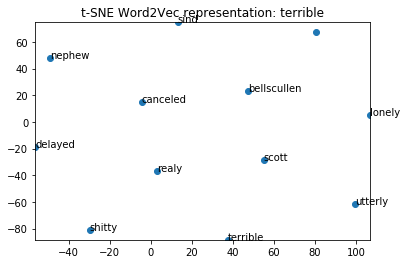

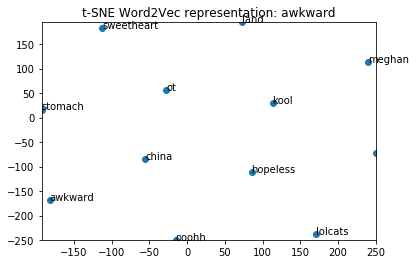

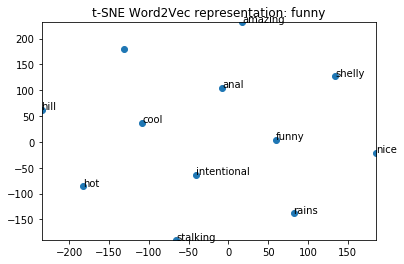

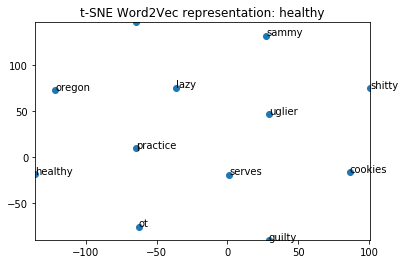

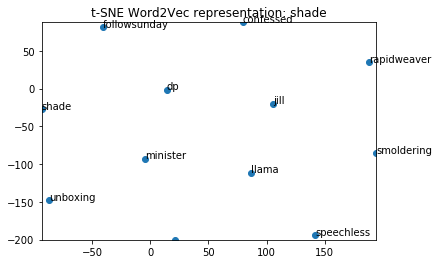

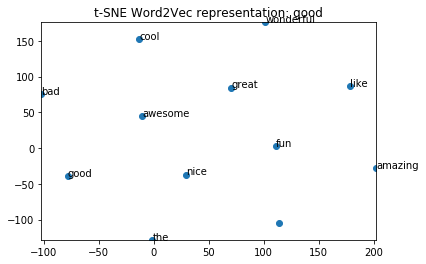

In [16]:
for word in ['terrible', 'awkward', 'funny', 'healthy', 'shade', 'good']:
    display_closestwords_tsnescatterplot(w2v, word)

### C. Classifiers on Word2Vec

**1. Define mean and tf-idf frequency**

https://github.com/nadbordrozd/blog_stuff/blob/master/classification_w2v/benchmarking_python3.ipynb

In [141]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
#---------------------------------------------------------------------------------------------------------------------#
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

**2. Create classifiers pipelines**

In [142]:
mult_nb = Pipeline([("count_vectorizer", CountVectorizer()),("multinomial naïve bayes", MultinomialNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer()),("multinomial naïve bayes", MultinomialNB())])
svc = Pipeline([("count_vectorizer", CountVectorizer()),("support vector machine", SVC())])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer()),("support vector machine", SVC())])
etree = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_clf)),("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_clf)),("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [191]:
tweets = []
print(len(X_w2v))
for tweet in X_w2v:
    tweets.append(tweet[0])

24963


In [192]:
simple_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
]

etree_models = [
    ("etree", etree),
    ("etree_tfidf", etree_tfidf)
]

simple_scores = [(name, cross_val_score(model, tweets, Y_tweets, cv=5).mean()) for name, model in simple_models]
etree_scores = [(name, cross_val_score(model, reviews, Y_tweets, cv=5).mean()) for name, model in etree_models]

unsorted_scores = simple_scores + etree_scores
scores = sorted(unsorted_scores, key=lambda x: -x[1])
print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model            score
-------------  -------
mult_nb         0.7334
mult_nb_tfidf   0.7286
etree           0.6874
etree_tfidf     0.6806
svc             0.5132
svc_tfidf       0.5132


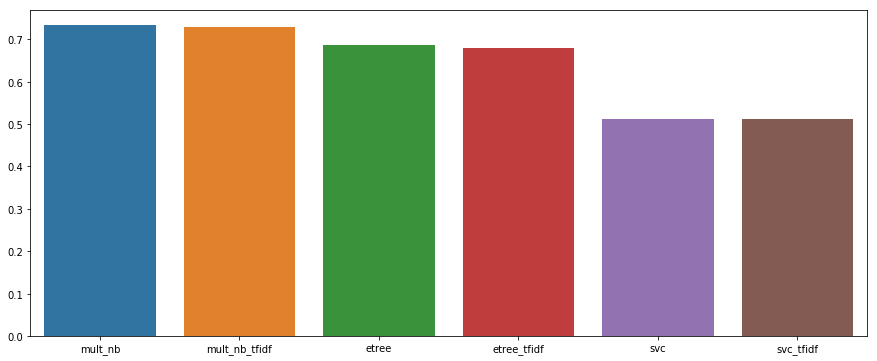

In [193]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

## III. Topic Modeling

### A. Loading dataset

In [160]:
X_topic = X_clean_tweets_pd.head(10000)

In [161]:
X_topic = X_topic.drop(['Sentiment'], axis=1).dropna(axis=0)
X_topic_list = X_topic.values.tolist()
sentences = []
for sentence in X_topic_list:
    sentences.append(sentence[0])

In [163]:
n_samples = len(sentences)
n_features = 1000
n_top_words = 20

In [185]:
def get_topics(model, feature_names, n_top_words):
    word_dict = {}
    iter_topics = 1
    for topic_idx, topic in enumerate(model.components_):
        words = []
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            words.append(feature_names[i])
        word_dict['Topic # ' + str(iter_topics)] = words;
        iter_topics += 1
    return pd.DataFrame(word_dict);

### B. TF-IDF representation

In [178]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(sentences)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(sentences)


Topics in NMF model (Frobenius norm):
Topic #0: day bad tomorrow nice having happy sleep great mothers amazing wonderful today best long hope musicmonday way ve thanks beautiful
Topic #1: followfriday follow thanks great people tweets awesome twitter thank ll tweeps person guys writer cool ff friend nice ppl books
Topic #2: just got need saw let wanna away twitter song home new things lol bad missed thought broke oh help called
Topic #3: love ll song music night follow lol amazing guys ff musicmonday god friends best haha tweets oh come time say
Topic #4: like feel look looks dont shit really better ve bgt ll crying act night times tonight guys sounds way don
Topic #5: miss ll gonna home friend wish awesome phone friends iremember days tired im iphone damn mad years oh times really
Topic #6: want don really new write friends doesn doing mail happy tonight drive miley sleep hug eat house does ugh dont
Topic #7: good night morning feel mood weekend really having great luck right people 

### C. NMF(Non-Negative Matrix Factorization)

In [227]:
values = range(1,20)
models_nmf = []
re_list = []
for n_components in values:
    nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5).fit(tfidf)
    models_nmf.append(nmf)
    re_list.append(nmf.reconstruction_err_**2)

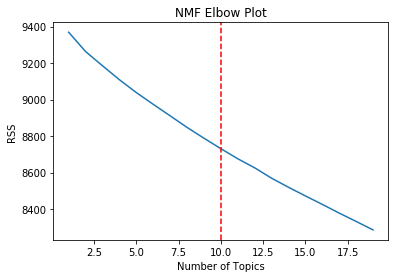

In [225]:
elbow = 10
plt.plot(values, re_list)
plt.title('NMF Elbow Plot')
plt.xlabel('Number of Topics')
plt.ylabel('RSS')
plt.axvline(elbow, color='r', linestyle='dashed')

In [186]:
print("\nTopics in NMF model (Frobenius norm):")
model_nmf = models_nmf[elbow]
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
get_topics(model_nmf, tfidf_feature_names, n_top_words)


Topics in NMF model (Frobenius norm):


,Topic # 1,Topic # 2,Topic # 3,Topic # 4,Topic # 5,Topic # 6,Topic # 7,Topic # 8,Topic # 9,Topic # 10
0,day,followfriday,just,love,like,miss,want,good,today,don
1,bad,follow,got,ll,feel,ll,don,night,sad,know
2,tomorrow,thanks,need,song,look,gonna,really,morning,going,think
3,nice,great,saw,music,looks,home,new,feel,work,ll
4,having,people,let,night,dont,friend,write,mood,im,really
5,happy,tweets,wanna,follow,shit,wish,friends,weekend,time,wanna
6,sleep,awesome,away,lol,really,awesome,doesn,really,hate,need
7,great,twitter,twitter,amazing,better,phone,doing,having,got,feel
8,mothers,thank,song,guys,ve,friends,mail,great,happy,people
9,amazing,ll,home,ff,bgt,iremember,happy,luck,tomorrow,dont


### D. LDA(Latent Dirichlet Allocation)

In [211]:
values = range(1,30)
models = []
perplexities = []
for n_components in values:
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method='online', learning_offset=50., random_state=0)
    lda.fit(tf)
    models.append(lda)
    perplexities.append(lda.perplexity(tf))

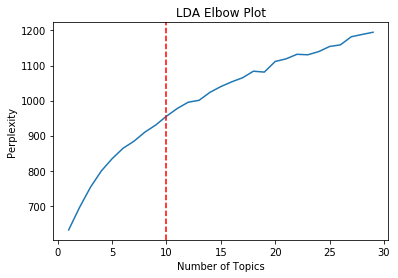

In [216]:
elbow = 10
plt.plot(values, perplexities)
plt.title('LDA Elbow Plot')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.axvline(elbow, color='r', linestyle='dashed')

In [217]:
print("\nTopics in LDA model:")
model = models[elbow]
tf_feature_names = tf_vectorizer.get_feature_names()
get_topics(model, tf_feature_names, n_top_words)


Topics in LDA model:


,Topic # 1,Topic # 2,Topic # 3,Topic # 4,Topic # 5,Topic # 6,Topic # 7,Topic # 8,Topic # 9,Topic # 10,Topic # 11
0,come,want,just,love,going,followfriday,great,day,good,time,im
1,tonight,don,got,follow,feel,squarespace,people,twitter,lol,need,ve
2,getting,today,better,make,like,tweet,myweakness,bad,night,sad,morning
3,school,know,work,musicmonday,ll,lost,wish,know,miss,right,just
4,oh,iphone,home,wanna,life,weekend,hate,new,tomorrow,really,makes
5,dont,old,happy,ff,don,win,music,won,day,song,like
6,sick,having,things,away,bed,wait,inaperfectworld,fun,awesome,think,look
7,long,left,nice,world,days,wanted,live,let,hope,way,tweets
8,soon,help,girl,sleep,little,tired,hours,man,did,gonna,said
9,leave,doesn,baby,friends,missing,making,trending,thanks,like,today,smile
